In [1]:
import pandas as pd
from scipy.stats import ttest_ind,ttest_ind_from_stats, f_oneway
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier

In [2]:
ticket_stats_df=pd.read_csv("data/StopData1.csv")
id_ward_df = pd.read_csv("data/StopData2.csv")



In [3]:
court_df=pd.read_csv("data/CourtsDataV2.csv")

In [4]:
ticket_stats_df.head()

,stop_id,officer_id,driver_id,driver_age,driver_sex,ticket
0,1279,D,1031,43.0,f,False
1,3626,C,43,53.0,m,True
2,4329,C,4527,21.0,m,True
3,3165,A,1408,31.0,f,True
4,4876,B,3090,28.0,m,True


In [5]:
id_ward_df.head()

,stop_id,ward
0,2679,5
1,4758,5
2,3420,4
3,17,8
4,1060,5


In [6]:
court_df.head()

,stop_id,ticket_amount,status
0,3420,55,challenged
1,2865,40,challenged
2,3595,10,challenged
3,2597,60,challenged
4,409,195,overdue


In [7]:
mega_df=court_df.merge(ticket_stats_df,on='stop_id')

In [8]:
mega_df.head()

,stop_id,ticket_amount,status,officer_id,driver_id,driver_age,driver_sex,ticket
0,3420,55,challenged,A,2298,44.0,f,True
1,2865,40,challenged,C,1430,16.0,m,True
2,3595,10,challenged,E,686,32.0,m,True
3,2597,60,challenged,D,1822,46.0,m,True
4,409,195,overdue,D,1156,48.0,f,True


In [9]:
mega_df['ticket'].value_counts()

True    636
Name: ticket, dtype: int64

In [10]:
mega_df.groupby('driver_sex')['ticket_amount'].mean()

driver_sex
f    76.937716
m    52.680115
Name: ticket_amount, dtype: float64

In [11]:
ttest_ind_from_stats(mega_df.groupby('driver_sex')['ticket_amount'].mean()[0],
                    mega_df.groupby('driver_sex')['ticket_amount'].std()[0],
                    mega_df.groupby('driver_sex')['ticket_amount'].count()[0],
                    mega_df.groupby('driver_sex')['ticket_amount'].mean()[1],
                    mega_df.groupby('driver_sex')['ticket_amount'].std()[1],
                    mega_df.groupby('driver_sex')['ticket_amount'].count()[1])

Ttest_indResult(statistic=7.358312500780395, pvalue=5.793255194211782e-13)

In [12]:
mega_df.groupby('officer_id')['ticket_amount'].mean()

officer_id
A    56.904762
B    63.771186
C    68.475177
D    65.403226
E    63.425197
Name: ticket_amount, dtype: float64

In [13]:
f_oneway(mega_df['ticket_amount'][mega_df['officer_id']=='A'],
         mega_df['ticket_amount'][mega_df['officer_id']=='B'],
         mega_df['ticket_amount'][mega_df['officer_id']=='C'],
         mega_df['ticket_amount'][mega_df['officer_id']=='D'],
         mega_df['ticket_amount'][mega_df['officer_id']=='E']
        )

F_onewayResult(statistic=1.2680279837557158, pvalue=0.28121351622973173)

In [14]:
super_mega_df=mega_df.merge(id_ward_df,on='stop_id')

In [15]:
super_mega_df.groupby('ward')['ticket_amount'].mean()

ward
1    68.380282
2    66.136364
3    58.101266
4    61.125000
5    69.411765
6    61.329114
7    62.700000
8    64.301075
Name: ticket_amount, dtype: float64

In [16]:
f_oneway(super_mega_df['ticket_amount'][super_mega_df['ward']==1],
         super_mega_df['ticket_amount'][super_mega_df['ward']==2],
         super_mega_df['ticket_amount'][super_mega_df['ward']==3],
         super_mega_df['ticket_amount'][super_mega_df['ward']==4],
         super_mega_df['ticket_amount'][super_mega_df['ward']==5],
         super_mega_df['ticket_amount'][super_mega_df['ward']==6],
         super_mega_df['ticket_amount'][super_mega_df['ward']==7],
         super_mega_df['ticket_amount'][super_mega_df['ward']==8],
        )

F_onewayResult(statistic=0.5935160622746761, pvalue=0.7614817154907292)

In [17]:
super_mega_df['status'].value_counts()

challenged    246
paid          229
overdue       119
pending        42
Name: status, dtype: int64

In [22]:
def status_to_numeric(x):
    if x == 'challenged':
        return 1
    elif x == 'paid':
        return 2
    elif x == 'overdue':
        return 3
    elif x == 'pending':
        return 4
    else:
        return 99999

In [23]:
super_mega_df.head()

,stop_id,ticket_amount,status,officer_id,driver_id,driver_age,driver_sex,ticket,ward
0,3420,55,challenged,A,2298,44.0,f,True,4
1,2865,40,challenged,C,1430,16.0,m,True,3
2,3595,10,challenged,E,686,32.0,m,True,6
3,2597,60,challenged,D,1822,46.0,m,True,4
4,409,195,overdue,D,1156,48.0,f,True,7


In [24]:
model_df=super_mega_df.copy()

In [25]:
model_df['status']=model_df['status'].map(lambda x: status_to_numeric(x))

In [26]:
model_df['large_ticket']=model_df['ticket_amount'].map(lambda x: 1 if x>=100 else 0)

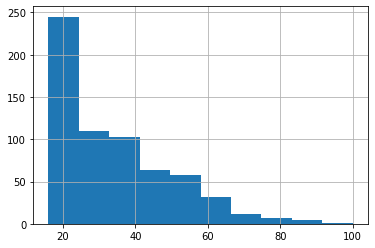

In [27]:
model_df['driver_age'].hist()

In [28]:
model_df['younger_than_25'] = model_df['driver_age'].map(lambda x: 0 if x>= 26 else 1)

In [29]:
model_df['older_than_55'] = model_df['driver_age'].map(lambda x: 1 if x>= 45 else 0)

In [30]:
model_df['driver_sex']=model_df['driver_sex'].map(lambda x: 1 if x =='m' else 0)

In [31]:
model_df.head(2)

,stop_id,ticket_amount,status,officer_id,driver_id,driver_age,driver_sex,ticket,ward,large_ticket,younger_than_25,older_than_55
0,3420,55,1,A,2298,44.0,0,True,4,0,0,0
1,2865,40,1,C,1430,16.0,1,True,3,0,1,0


In [32]:
# officer_dummies=pd.get_dummies(data=model_df['officer_id'],drop_first=True)

In [33]:
# model_df=pd.concat([model_df,officer_dummies],axis=1)

In [104]:
model_df=pd.get_dummies(model_df,prefix='officer_id')

In [105]:
model_df.head()

,stop_id,ticket_amount,status,driver_id,driver_age,driver_sex,ticket,ward,large_ticket,younger_than_25,...,E,interaction 1,interaction 2,interaction 3,interaction 4,officer_id_A,officer_id_B,officer_id_C,officer_id_D,officer_id_E
0,3420,55,1,2298,44.0,0,True,4,0,0,...,0,2420.0,3025,1936.0,5856400.0,1,0,0,0,0
1,2865,40,1,1430,16.0,1,True,3,0,1,...,0,640.0,1600,256.0,409600.0,0,0,1,0,0
2,3595,10,1,686,32.0,1,True,6,0,0,...,1,320.0,100,1024.0,102400.0,0,0,0,0,1
3,2597,60,1,1822,46.0,1,True,4,0,0,...,0,2760.0,3600,2116.0,7617600.0,0,0,0,1,0
4,409,195,3,1156,48.0,0,True,7,1,0,...,0,9360.0,38025,2304.0,87609600.0,0,0,0,1,0


In [106]:
model_df.columns

Index(['stop_id', 'ticket_amount', 'status', 'driver_id', 'driver_age',
       'driver_sex', 'ticket', 'ward', 'large_ticket', 'younger_than_25',
       'older_than_55', 'B', 'C', 'D', 'E', 'interaction 1', 'interaction 2',
       'interaction 3', 'interaction 4', 'officer_id_A', 'officer_id_B',
       'officer_id_C', 'officer_id_D', 'officer_id_E'],
      dtype='object')

In [107]:
model_df['interaction 1'] = model_df['driver_age']*model_df['ticket_amount']
model_df['interaction 2']=model_df['ticket_amount']**2
model_df['interaction 3'] = model_df['driver_age']**2
model_df['interaction 4'] = model_df['interaction 1']**2

In [108]:
 model_df.head()

,stop_id,ticket_amount,status,driver_id,driver_age,driver_sex,ticket,ward,large_ticket,younger_than_25,...,E,interaction 1,interaction 2,interaction 3,interaction 4,officer_id_A,officer_id_B,officer_id_C,officer_id_D,officer_id_E
0,3420,55,1,2298,44.0,0,True,4,0,0,...,0,2420.0,3025,1936.0,5856400.0,1,0,0,0,0
1,2865,40,1,1430,16.0,1,True,3,0,1,...,0,640.0,1600,256.0,409600.0,0,0,1,0,0
2,3595,10,1,686,32.0,1,True,6,0,0,...,1,320.0,100,1024.0,102400.0,0,0,0,0,1
3,2597,60,1,1822,46.0,1,True,4,0,0,...,0,2760.0,3600,2116.0,7617600.0,0,0,0,1,0
4,409,195,3,1156,48.0,0,True,7,1,0,...,0,9360.0,38025,2304.0,87609600.0,0,0,0,1,0


In [114]:
X = model_df.drop([
  #'officer_id',
    'driver_id','stop_id','ticket',
                  'status'],axis=1)
y = model_df['status']

In [115]:
X

,ticket_amount,driver_age,driver_sex,ward,large_ticket,younger_than_25,older_than_55,B,C,D,E,interaction 1,interaction 2,interaction 3,interaction 4,officer_id_A,officer_id_B,officer_id_C,officer_id_D,officer_id_E
0,55,44.0,0,4,0,0,0,0,0,0,0,2420.0,3025,1936.0,5856400.0,1,0,0,0,0
1,40,16.0,1,3,0,1,0,0,1,0,0,640.0,1600,256.0,409600.0,0,0,1,0,0
2,10,32.0,1,6,0,0,0,0,0,0,1,320.0,100,1024.0,102400.0,0,0,0,0,1
3,60,46.0,1,4,0,0,1,0,0,1,0,2760.0,3600,2116.0,7617600.0,0,0,0,1,0
4,195,48.0,0,7,1,0,1,0,0,1,0,9360.0,38025,2304.0,87609600.0,0,0,0,1,0
5,20,23.0,1,2,0,1,0,0,0,0,0,460.0,400,529.0,211600.0,1,0,0,0,0
6,70,57.0,0,7,0,0,1,0,0,0,0,3990.0,4900,3249.0,15920100.0,1,0,0,0,0
7,75,40.0,1,8,0,0,0,0,0,0,0,3000.0,5625,1600.0,9000000.0,1,0,0,0,0
8,105,62.0,1,4,1,0,1,0,0,1,0,6510.0,11025,3844.0,42380100.0,0,0,0,1,0
9,10,30.0,1,8,0,0,0,0,0,0,1,300.0,100,900.0,90000.0,0,0,0,0,1


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=13)

In [117]:
gb = GradientBoostingClassifier()

In [118]:
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [119]:
gb.score(X_train,y_train)

0.8805031446540881

In [120]:
gb.score(X_test,y_test)

0.4591194968553459

In [121]:
model_df['status'].value_counts(normalize=True)

1    0.386792
2    0.360063
3    0.187107
4    0.066038
Name: status, dtype: float64

In [122]:
y_test;

In [123]:
svc = SVC()

In [124]:
svc.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [125]:
svc.score(X_test,y_test)

0.3836477987421384

In [126]:
# sns.heatmap(model_df.corr()[['status']].sort_values('status'),annot=True)

In [127]:
GradientBoostingClassifier()

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [128]:
gb_params = {
    'learning_rate':[0.05,0.1],
    'n_estimators': [100,125,150],
    'min_samples_split':[2,4,8],
    'max_depth':[2,3],
    'min_samples_leaf':[1,2,3]
    
}

In [129]:
# gs = GridSearchCV(gb,param_grid=gb_params,cv=3)
# gs.fit(X_train, y_train)
# print(gs.best_score_)

# gs.best_params_

In [130]:
gb = GradientBoostingClassifier(
learning_rate=0.05,
max_depth=2,
min_samples_split=4,
n_estimators=125)
gb.fit(X_train,y_train)
gb.score(X_test,y_test)
#0.459

0.5031446540880503

In [131]:
preds=gb.predict(X_test)

In [132]:
model_df['status']

0      1
1      1
2      1
3      1
4      3
5      2
6      4
7      3
8      1
9      4
10     4
11     1
12     3
13     1
14     2
15     1
16     2
17     2
18     2
19     2
20     1
21     2
22     3
23     3
24     4
25     1
26     2
27     1
28     2
29     1
      ..
606    2
607    2
608    2
609    3
610    1
611    3
612    1
613    1
614    4
615    4
616    2
617    2
618    2
619    1
620    2
621    3
622    2
623    1
624    2
625    1
626    1
627    3
628    4
629    1
630    2
631    1
632    1
633    3
634    1
635    1
Name: status, Length: 636, dtype: int64

In [133]:
model_df['status'].value_counts().index

Int64Index([1, 2, 3, 4], dtype='int64')

<BarContainer object of 4 artists>

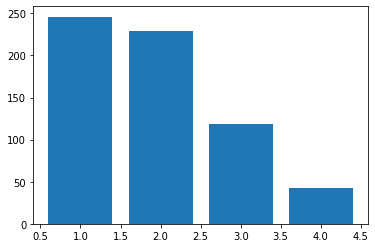

In [134]:
plt.bar(model_df['status'].value_counts().index,model_df['status'].value_counts())

<BarContainer object of 4 artists>

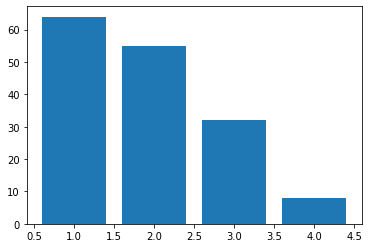

In [135]:
plt.bar(y_test.value_counts().index,y_test.value_counts())

In [136]:
preds=pd.DataFrame(preds,columns=['a'])

In [137]:
preds;

In [138]:
preds.columns

Index(['a'], dtype='object')

<BarContainer object of 4 artists>

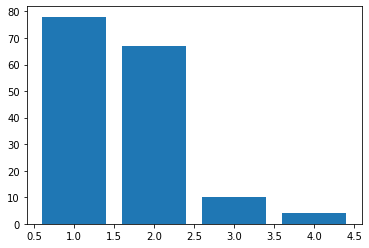

In [139]:
plt.bar(preds['a'].value_counts().index,preds['a'].value_counts())

([array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0.

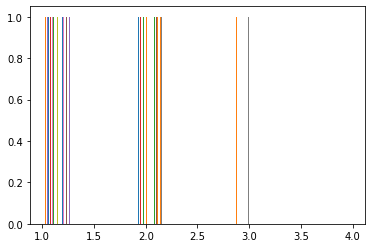

In [140]:
plt.hist(preds)

In [141]:
gb=GradientBoostingClassifier()

In [142]:
ovr = OneVsRestClassifier(gb)

In [143]:
ovr.fit(X_train,y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimato

In [144]:
ovr.score(X_test,y_test)

0.44654088050314467

In [145]:
preds = ovr.predict(X_test)